# Installing Model Visualizer

In [1]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 13.4 MB/s eta 0:00:00


# Fetch Necessary Libraries

In [2]:
import plotly.offline as pyo
pyo.init_notebook_mode()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
import random
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Loading data from file

In [ ]:
def Create_Directory_DataFrame():
    df =pd.DataFrame(columns=['Class','Location'])
    basedir = '../input/leapgestrecog/leapGestRecog/'
    for folder in os.listdir(basedir):
        for Class in os.listdir(basedir+folder+'/'):
            for location in os.listdir(basedir+folder+'/'+Class+'/'):
                df = df.append({'Class':Class,'Location':basedir+folder+'/'+Class+'/'+location},ignore_index=True)
    df = df.sample(frac = 1)
    return df

In [ ]:
df = Create_Directory_DataFrame()
print(df.shape)
df.head()

(20000, 2)


Class                                           Location
13076  08_palm_moved  ../input/leapgestrecog/leapGestRecog/08/08_pal...
4511            09_c  ../input/leapgestrecog/leapGestRecog/06/09_c/f...
13254          07_ok  ../input/leapgestrecog/leapGestRecog/08/07_ok/...
191             02_l  ../input/leapgestrecog/leapGestRecog/07/02_l/f...
7828         03_fist  ../input/leapgestrecog/leapGestRecog/02/03_fis...

# Visualize Data

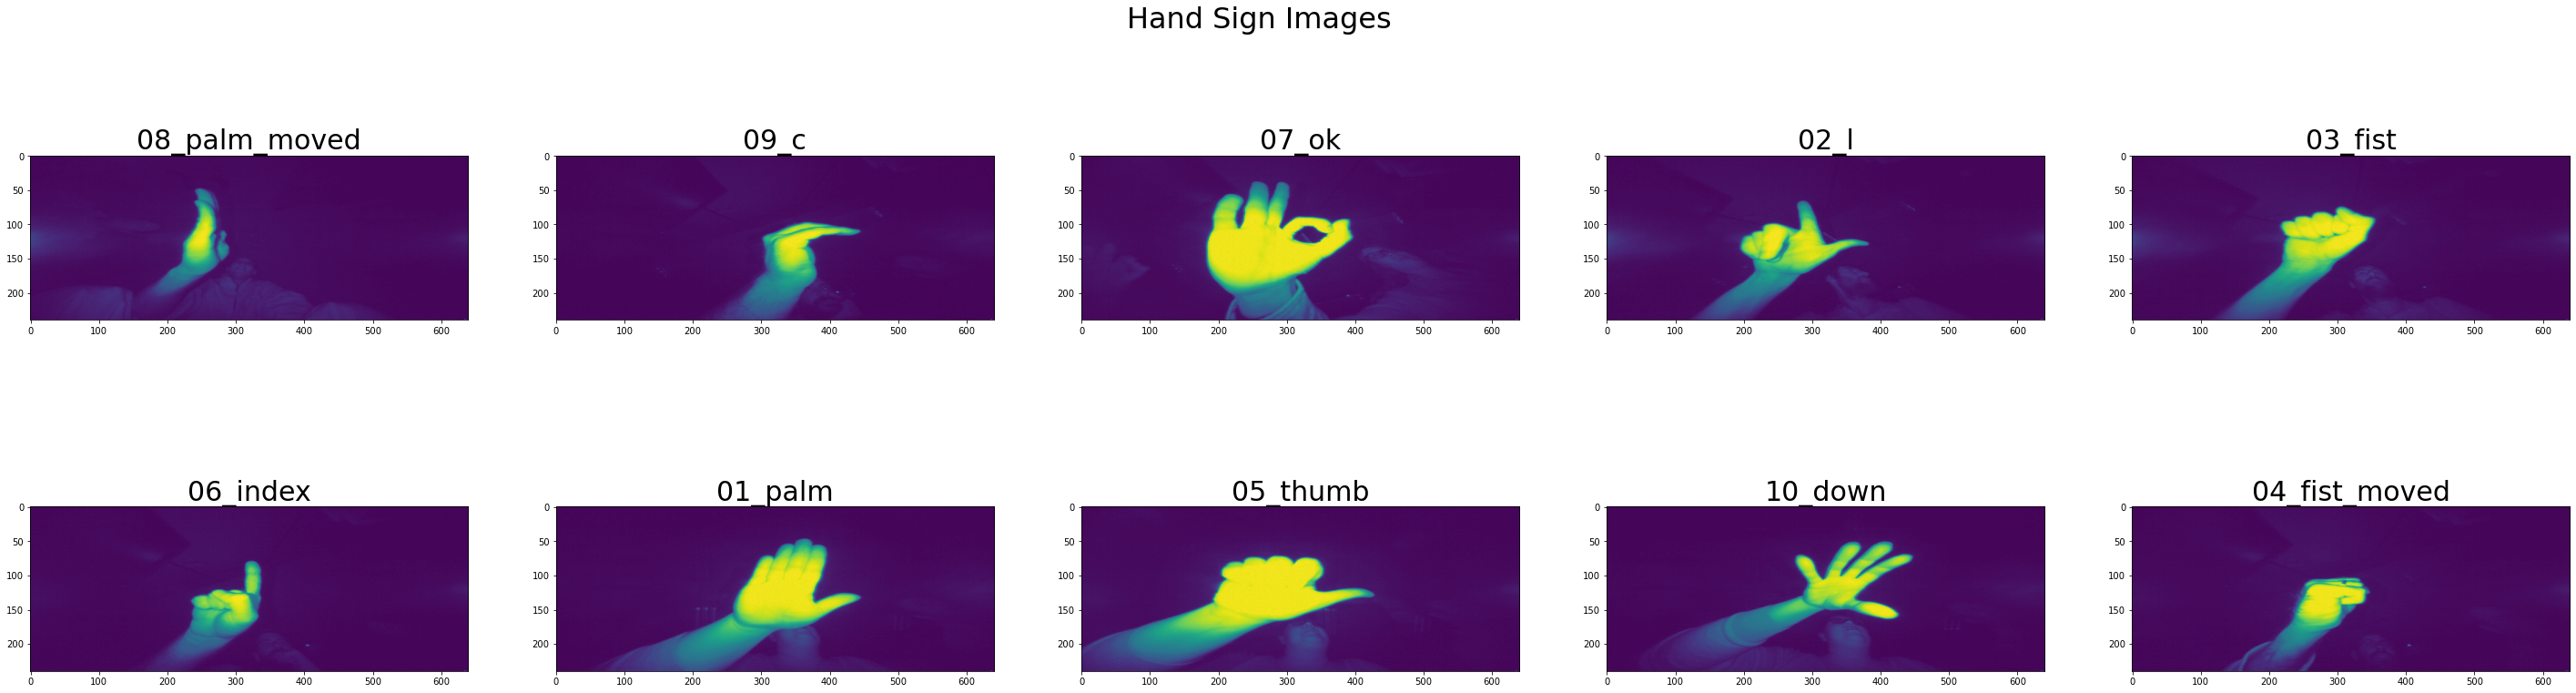

In [ ]:
count = 1
f = plt.figure(figsize=(50,13))
for Class in df['Class'].unique():
    seg = df[df['Class']==Class]
    address =  seg.sample().iloc[0]['Location']
    img = cv2.imread(address,0)
    ax = f.add_subplot(2, 5,count)
    ax = plt.imshow(img)
    ax = plt.title(Class,fontsize= 30)
    count = count + 1
plt.suptitle("Hand Sign Images", size = 32)
plt.show()

In [ ]:
img.shape

(240, 640)

# Define Constraints

In [ ]:
w , h= 64,64
final_class = 10

# Data Creation

In [ ]:
from tqdm import tqdm
train_image = []
for location in tqdm(df.iloc[:]['Location']):
    img = cv2.imread(location,0)
    img = cv2.resize(img, (w,h), interpolation = cv2.INTER_AREA)
    img = img.reshape(w,h,1)
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 20000/20000 [02:58<00:00, 112.36it/s]


In [ ]:
from sklearn.preprocessing import OneHotEncoder
y = np.array(df.iloc[:]['Class'])
y = y.reshape(y.shape[0],1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y)
print(enc.categories_)

[array(['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
       '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'],
      dtype=object)]


In [ ]:
y = enc.transform(y).toarray()

In [ ]:
print('Data   :   '+str(X.shape))
print('Output :   '+str(y.shape))

Data   :   (20000, 64, 64, 1)
Output :   (20000, 10)


# Samples

In [ ]:
print(X[0].reshape(w,h))

[[4 4 4 ... 4 5 5]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [4 4 4 ... 5 5 5]
 [4 4 4 ... 5 5 5]
 [4 4 4 ... 4 5 9]]


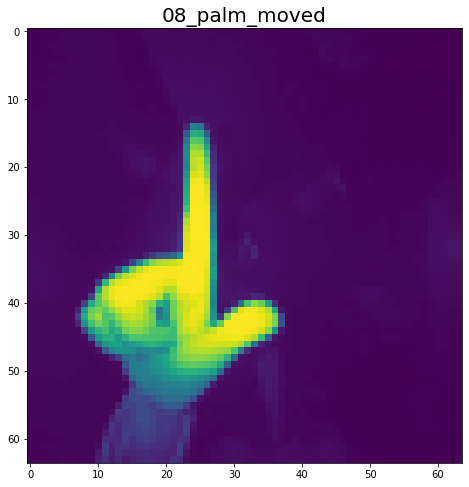

In [ ]:
plt.figure(figsize=(25,8))
plt.imshow(X[66].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,10))[0][0],size = 20)
plt.show()

In [ ]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

# Segmentation in Traing and Test Data Sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [ ]:
print('Train data    :'+str(X_train.shape))
print('Test data     :'+str(X_test.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

Train data    :(18000, 64, 64, 1)
Test data     :(2000, 64, 64, 1)
Train Output  :(18000, 10)
Test Output   :(2000, 10)


# Model

1. To make our model more modular and easier to understand, let's define some blocks. As we're building a convolution neural network, we'll create a convolution block and a dense layer block.
2. The following method will define the function to build our model for us. The Dropout layers are important as they "drop out," hence the name, certain nodes to reduce the likelikhood of the model overfitting.

For our metrics, we want to include precision and recall as they will provide use with a more informed picture of how good our model is. Accuracy tells us what fractions are the labels are correct. Since our data is not balanced, accuracy might give a skewed sense of a good model (i.e. a model that always predicts PNEUMONIA will be 74% accurate but is not a good model).

Precision is the number of true positives (TP) over the sum of TP and false positives (FP). It shows what fraction of labeled positives are actually correct.

Recall is the number of TP over the sum of TP and false negatves (FN). It shows what fraction of actual positives are correct.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    return block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block
def build_model(act , final_class , w , h ):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(w , h , 1)),

        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(final_class, activation='sigmoid')
    ])
    return model

In [ ]:
def wrap(Training_Output_Results , Opt , Act ,  history):
    epoch  = len(history.history['loss'])
    epochs = list(np.arange(1,epoch + 1,1))
    Optimizer = np.repeat(Opt,epoch).tolist()
    Activation = np.repeat(Act,epoch).tolist()
    cumiliated_res = {}
    cumiliated_res['Epochs']=epochs
    cumiliated_res['Optimizer']=Optimizer
    cumiliated_res['Activation_Function']=Activation
    cumiliated_res['Train_Loss']=history.history['loss']
    cumiliated_res['Train_Accuracy']=history.history['accuracy']
    cumiliated_res['Train_Precision']=history.history['precision']
    cumiliated_res['Train_Recall']=history.history['recall']
    cumiliated_res['Val_Loss']=history.history['val_loss']
    cumiliated_res['Val_Accuracy']=history.history['val_accuracy']
    cumiliated_res['Val_Precision']=history.history['val_precision']
    cumiliated_res['Val_Recall']=history.history['val_recall']
    convertDictionary = pd.DataFrame(cumiliated_res)
    Training_Output_Results = Training_Output_Results.append(convertDictionary)
    return Training_Output_Results

In [ ]:
Optimisers = ['RMSprop','Adam','Adadelta','Adagrad']
Activation_function =['relu','sigmoid','softmax','tanh','softsign','selu','elu']

# Final Model

In [ ]:
def Plot(history , name , model):
    model.save(name+'.h5')
    epochs = range(1,len(history.history['loss']) + 1)
    epochs = list(epochs)
    fig = make_subplots(rows=2, cols=4,subplot_titles=("Train Loss", "Train Accuracy" , "Train Precision","Train Recall", "Validation Loss", "Validation Accuracy",
                                                      "Validation Precision","Validation Recall"))
    fig.add_trace(go.Scatter(x=epochs, y=history.history['loss']), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['accuracy']), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['precision']), row=1, col=3)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['recall']), row=1, col=4)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_loss']), row=2, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_accuracy']), row=2, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_precision']), row=2, col=3)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_recall']), row=2, col=4)
    fig.update_layout(showlegend=False,height=1000, width=1200, title_text=name)
    pyo.iplot(fig, filename = 'Act_train_rec')

object : the model to train.      
-> X : our training data. Can be Vector, array or matrix      
-> Y : our training labels. Can be Vector, array or matrix       
-> Batch_size : it can take any integer value or NULL and by default, it will
be set to 32. It specifies no. of samples per gradient.      
-> Epochs : an integer and number of epochs we want to train our model for.      
-> Verbose : specifies verbosity mode(0 = silent, 1= progress bar, 2 = one
line per epoch).      
-> Shuffle : whether we want to shuffle our training data before each epoch.      
-> steps_per_epoch : it specifies the total number of steps taken before
one epoch has finished and started the next epoch. By default it values is set to NULL.

In [ ]:
model = build_model('relu', final_class ,w , h)
METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
]
model.compile(
                optimizer='RMSprop',
                loss='categorical_crossentropy',
                metrics=METRICS
        )
history = model.fit(X_train, y_train, epochs=50, validation_split=0.3, batch_size=15,verbose=1,shuffle=True)

Epoch 1/50
840/840 [==============================] - 11s 14ms/step - loss: 1.6733 - accuracy: 0.3891 - precision: 0.2080 - recall: 0.8803 - val_loss: 1.8367 - val_accuracy: 0.2780 - val_precision: 0.2528 - val_recall: 0.5691
Epoch 2/50
840/840 [==============================] - 11s 13ms/step - loss: 0.7186 - accuracy: 0.7358 - precision: 0.5273 - recall: 0.7536 - val_loss: 0.2630 - val_accuracy: 0.8639 - val_precision: 0.7886 - val_recall: 0.8794
Epoch 3/50
840/840 [==============================] - 11s 13ms/step - loss: 0.2618 - accuracy: 0.9217 - precision: 0.9279 - recall: 0.4691 - val_loss: 0.0215 - val_accuracy: 0.9935 - val_precision: 0.9998 - val_recall: 0.8815
Epoch 4/50
840/840 [==============================] - 12s 14ms/step - loss: 0.1450 - accuracy: 0.9593 - precision: 0.9871 - recall: 0.4065 - val_loss: 0.0230 - val_accuracy: 0.9933 - val_precision: 0.9996 - val_recall: 0.8237
Epoch 5/50
840/840 [==============================] - 11s 13ms/step - loss: 0.1188 - accuracy: 0

840/840 [==============================] - 11s 13ms/step - loss: 0.0198 - accuracy: 0.9957 - precision: 0.9996 - recall: 0.1838 - val_loss: 0.0131 - val_accuracy: 0.9981 - val_precision: 1.0000 - val_recall: 0.1011
Epoch 38/50
840/840 [==============================] - 11s 13ms/step - loss: 0.0277 - accuracy: 0.9953 - precision: 0.9971 - recall: 0.1880 - val_loss: 0.0118 - val_accuracy: 0.9991 - val_precision: 1.0000 - val_recall: 0.1181
Epoch 39/50
840/840 [==============================] - 11s 13ms/step - loss: 0.0236 - accuracy: 0.9946 - precision: 0.9990 - recall: 0.1656 - val_loss: 0.0130 - val_accuracy: 0.9989 - val_precision: 1.0000 - val_recall: 0.0761
Epoch 40/50
840/840 [==============================] - 11s 13ms/step - loss: 0.0193 - accuracy: 0.9952 - precision: 0.9974 - recall: 0.1810 - val_loss: 0.0035 - val_accuracy: 0.9996 - val_precision: 1.0000 - val_recall: 9.2593e-04
Epoch 41/50
840/840 [==============================] - 12s 14ms/step - loss: 0.0312 - accuracy: 0.99

In [ ]:
Plot(history , 'final_model',model)

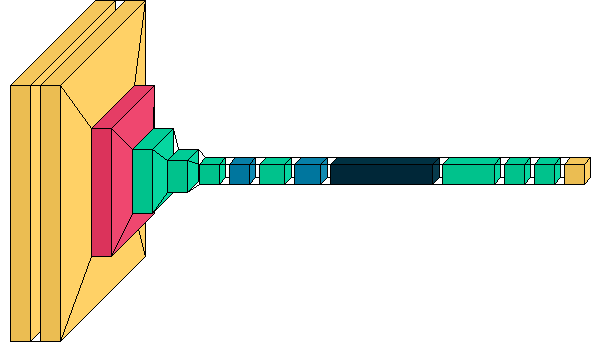

In [ ]:
import visualkeras
visualkeras.layered_view(model)

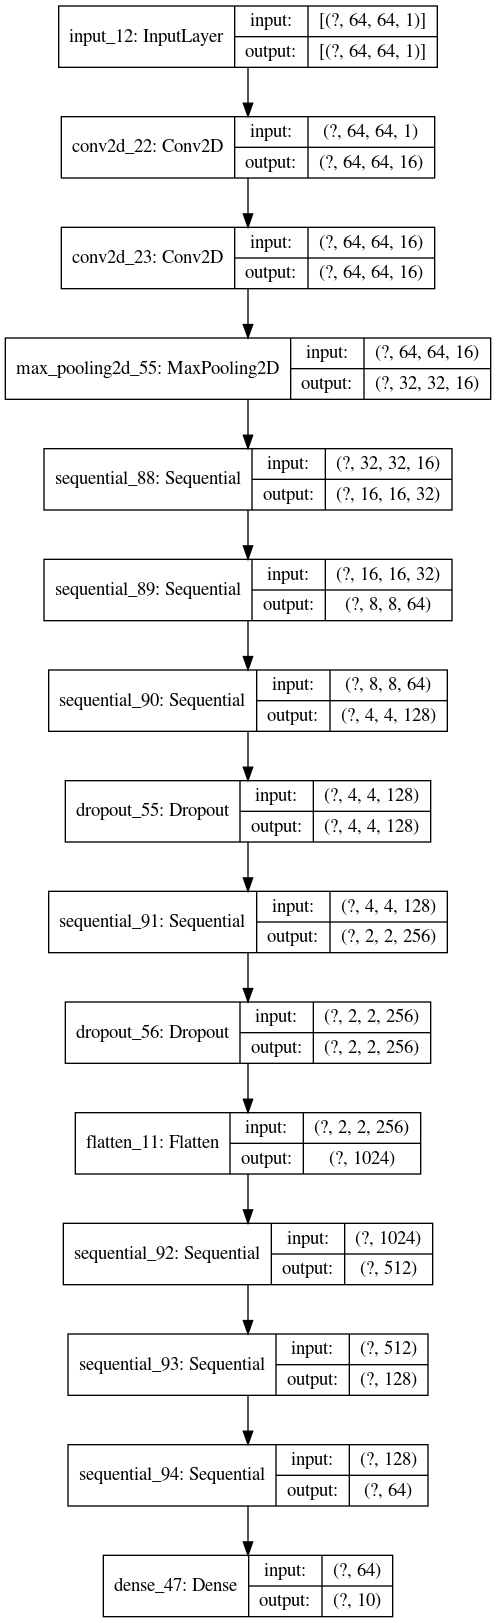

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

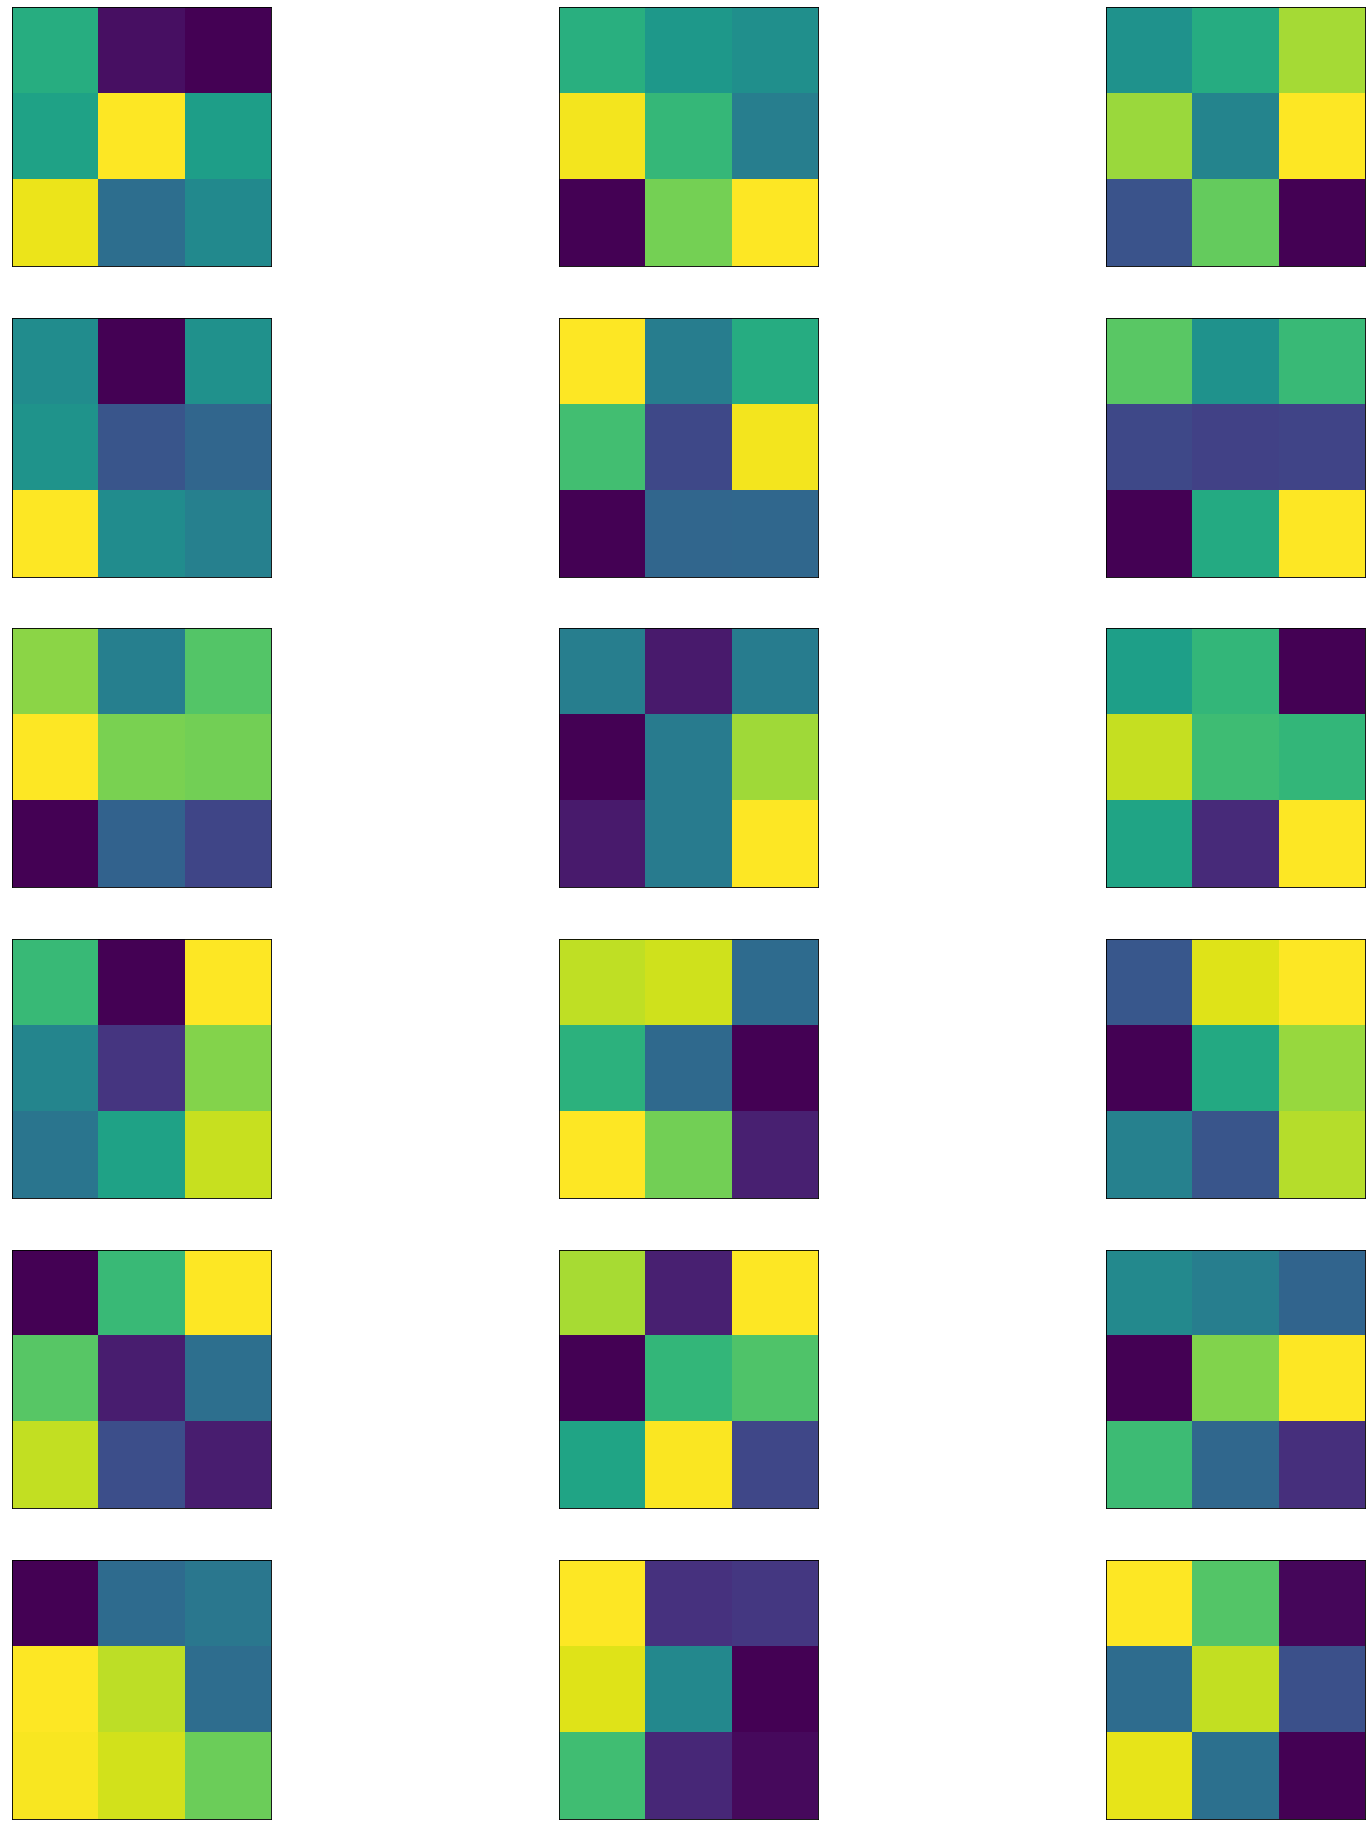

In [ ]:
from matplotlib import pyplot
from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters,3 , ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j])
		ix += 1
# show the figure
pyplot.show()

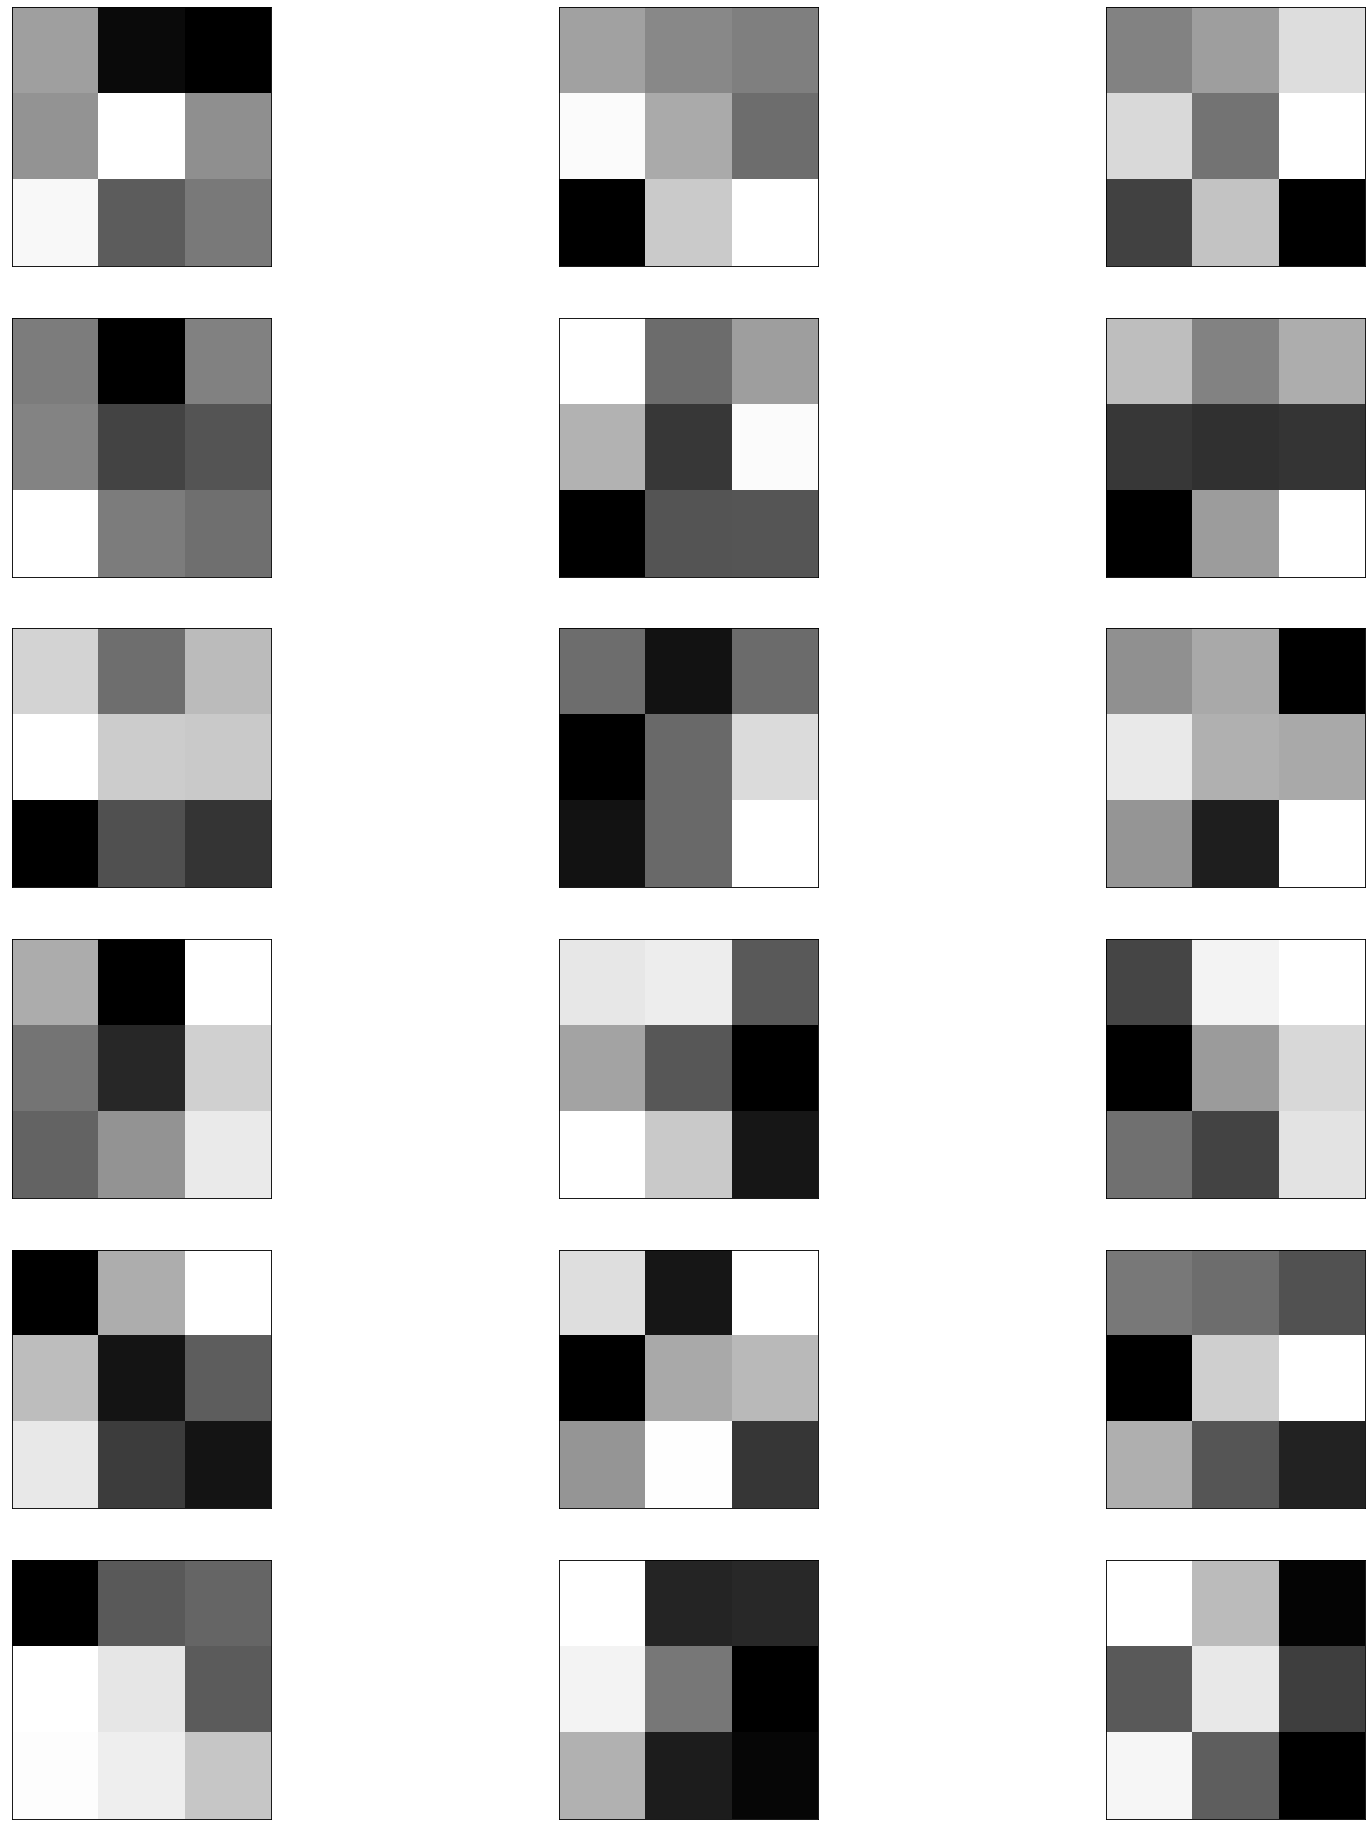

In [ ]:
from matplotlib import pyplot
from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters,3 , ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j],cmap='gray')
		ix += 1
# show the figure
pyplot.show()

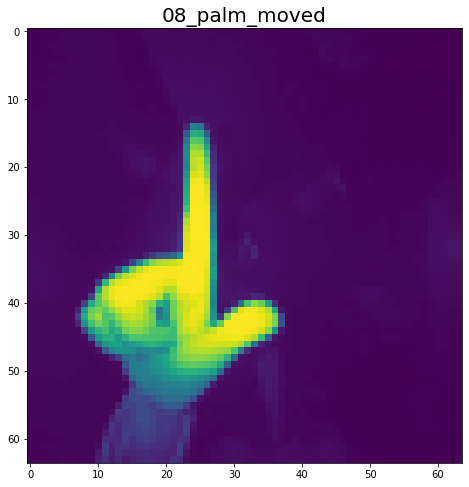

In [ ]:
plt.figure(figsize=(25,8))
plt.imshow(X[66].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,10))[0][0],size = 20)
plt.show()

In [ ]:
from keras.models import Model
from matplotlib.pyplot import figure
from numpy import expand_dims
def image_transform_gray(image):
    img = expand_dims(image, axis=0)
    model1 = Model(inputs=model.inputs, outputs=model.layers[0].output)
    feature_maps = model1.predict(img)
    figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
    square = 4
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(feature_maps[0, :, :, ix-1],cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()
def image_transform(image):
    img = expand_dims(image, axis=0)
    model1 = Model(inputs=model.inputs, outputs=model.layers[0].output)
    feature_maps = model1.predict(img)
    figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
    square = 4
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(feature_maps[0, :, :, ix-1])
            ix += 1
    # show the figure
    pyplot.show()

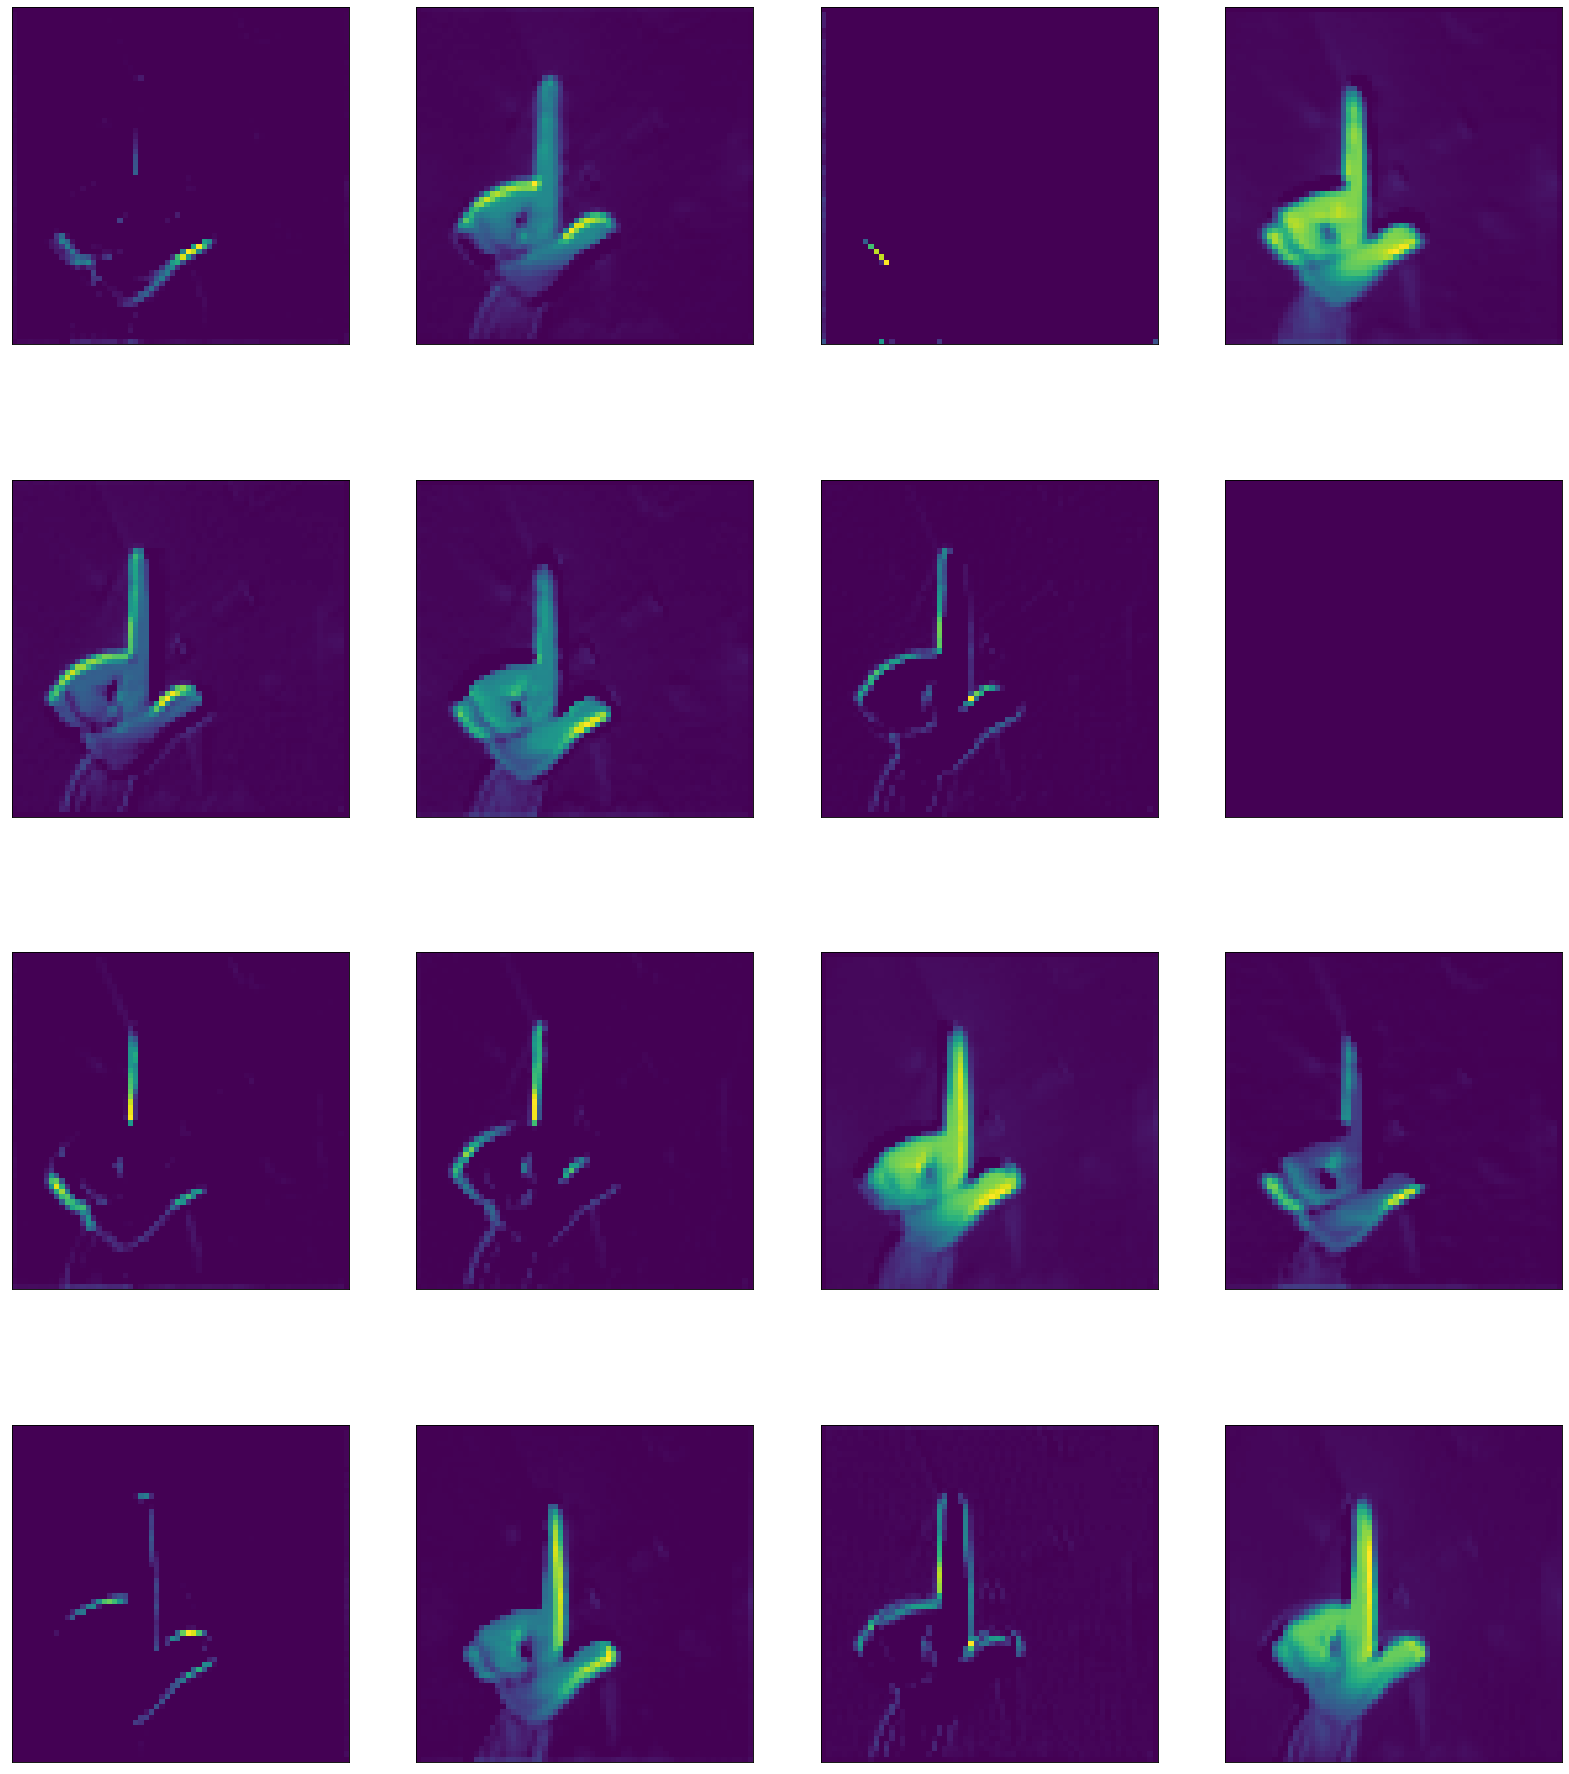

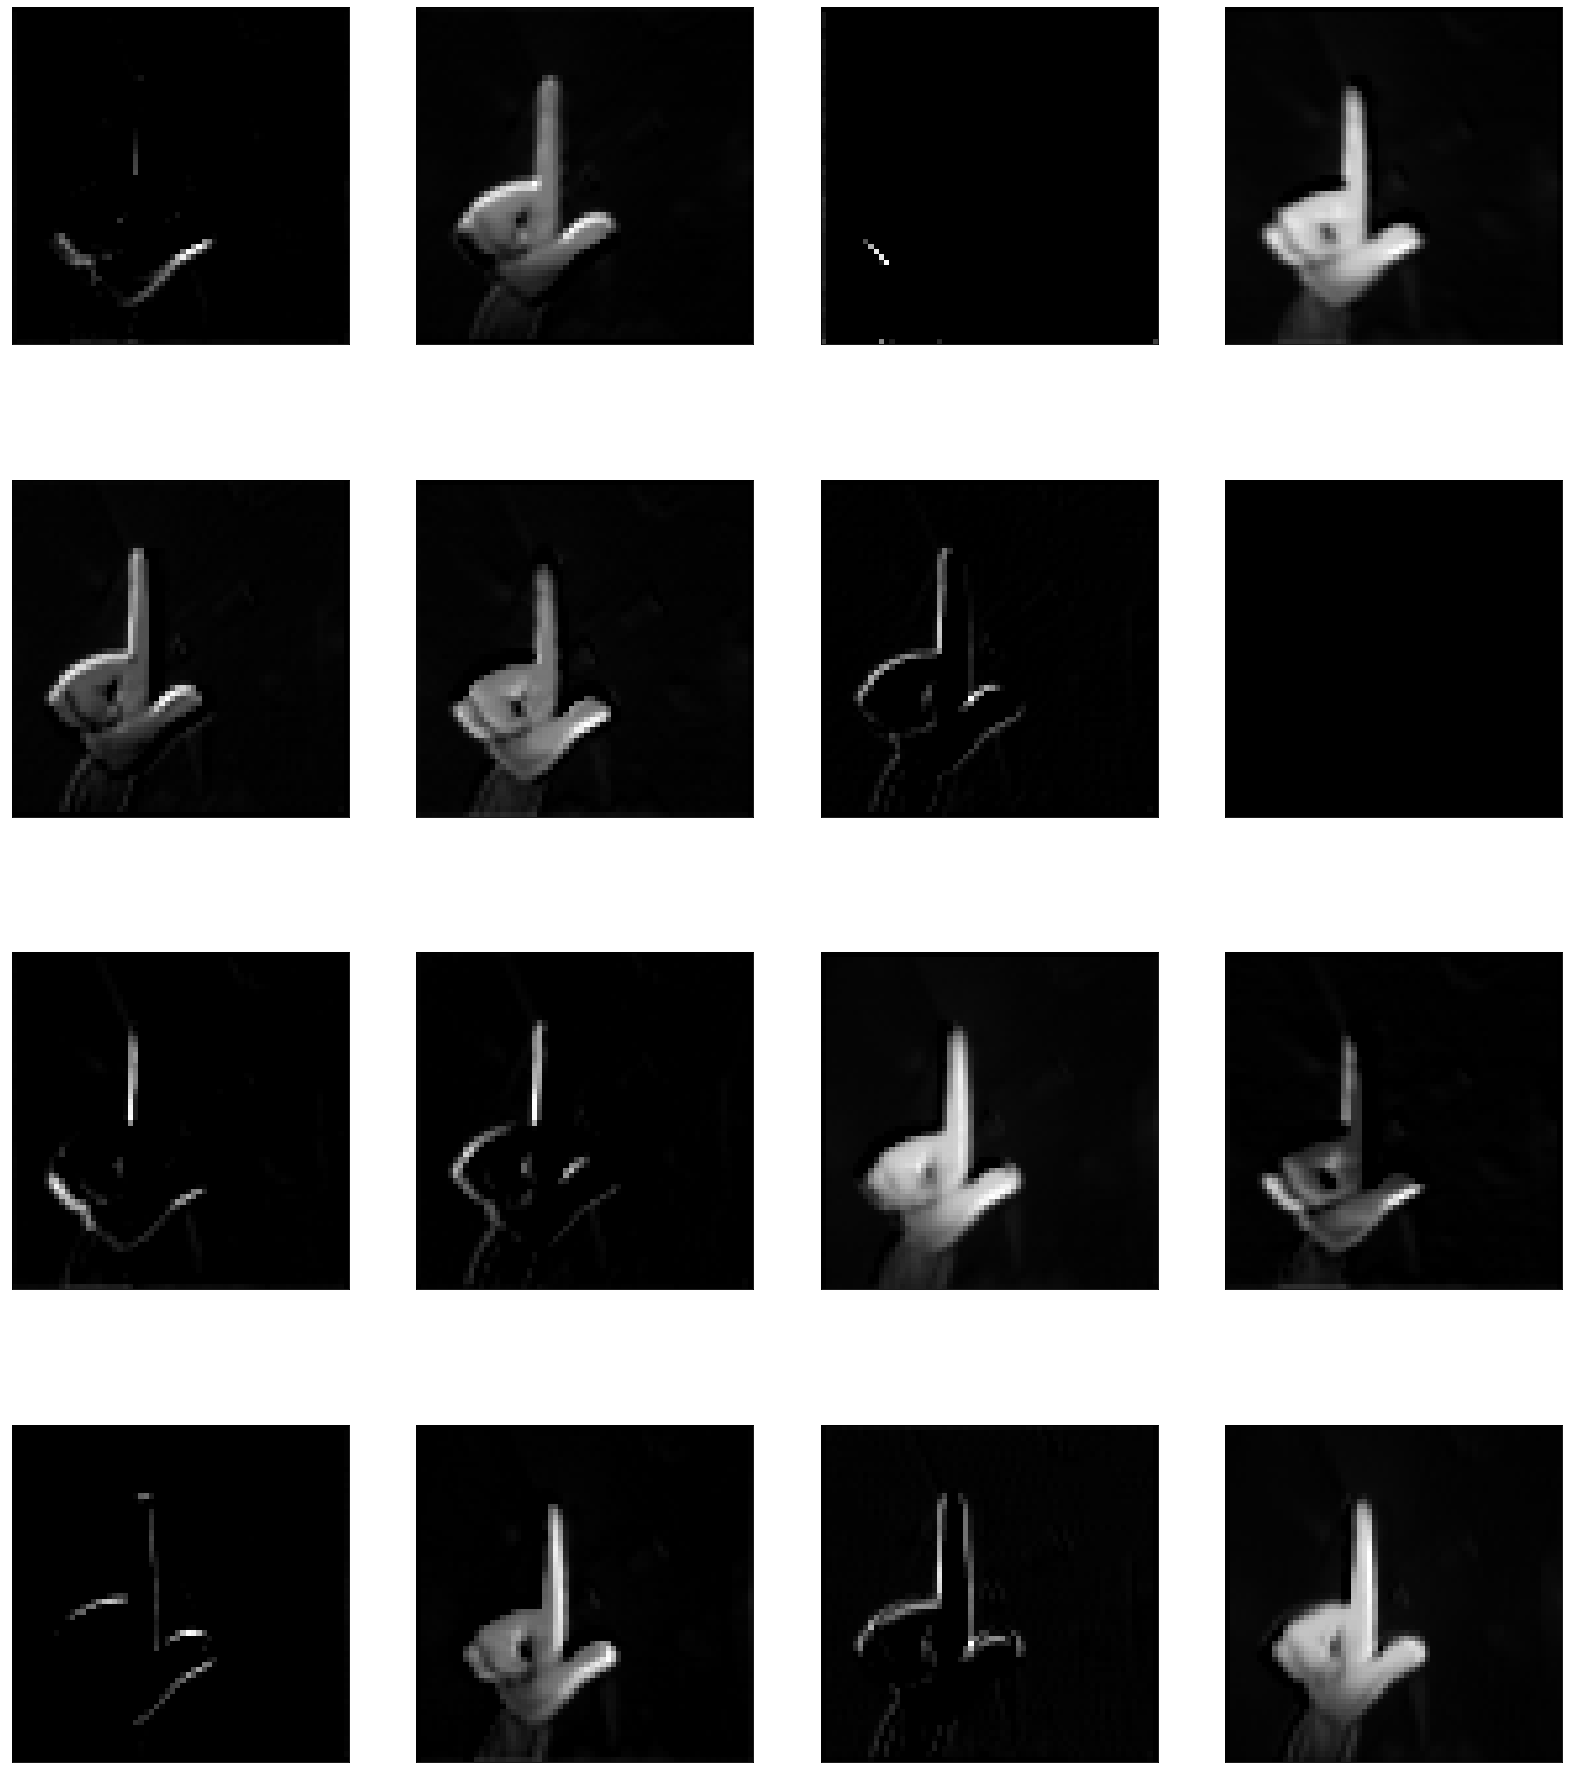

In [ ]:
image_transform(X[66])
image_transform_gray(X[66])

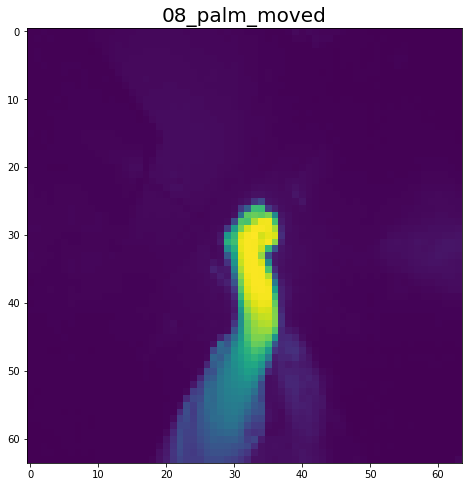

In [ ]:
plt.figure(figsize=(25,8))
plt.imshow(X[56].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,10))[0][0],size = 20)
plt.show()

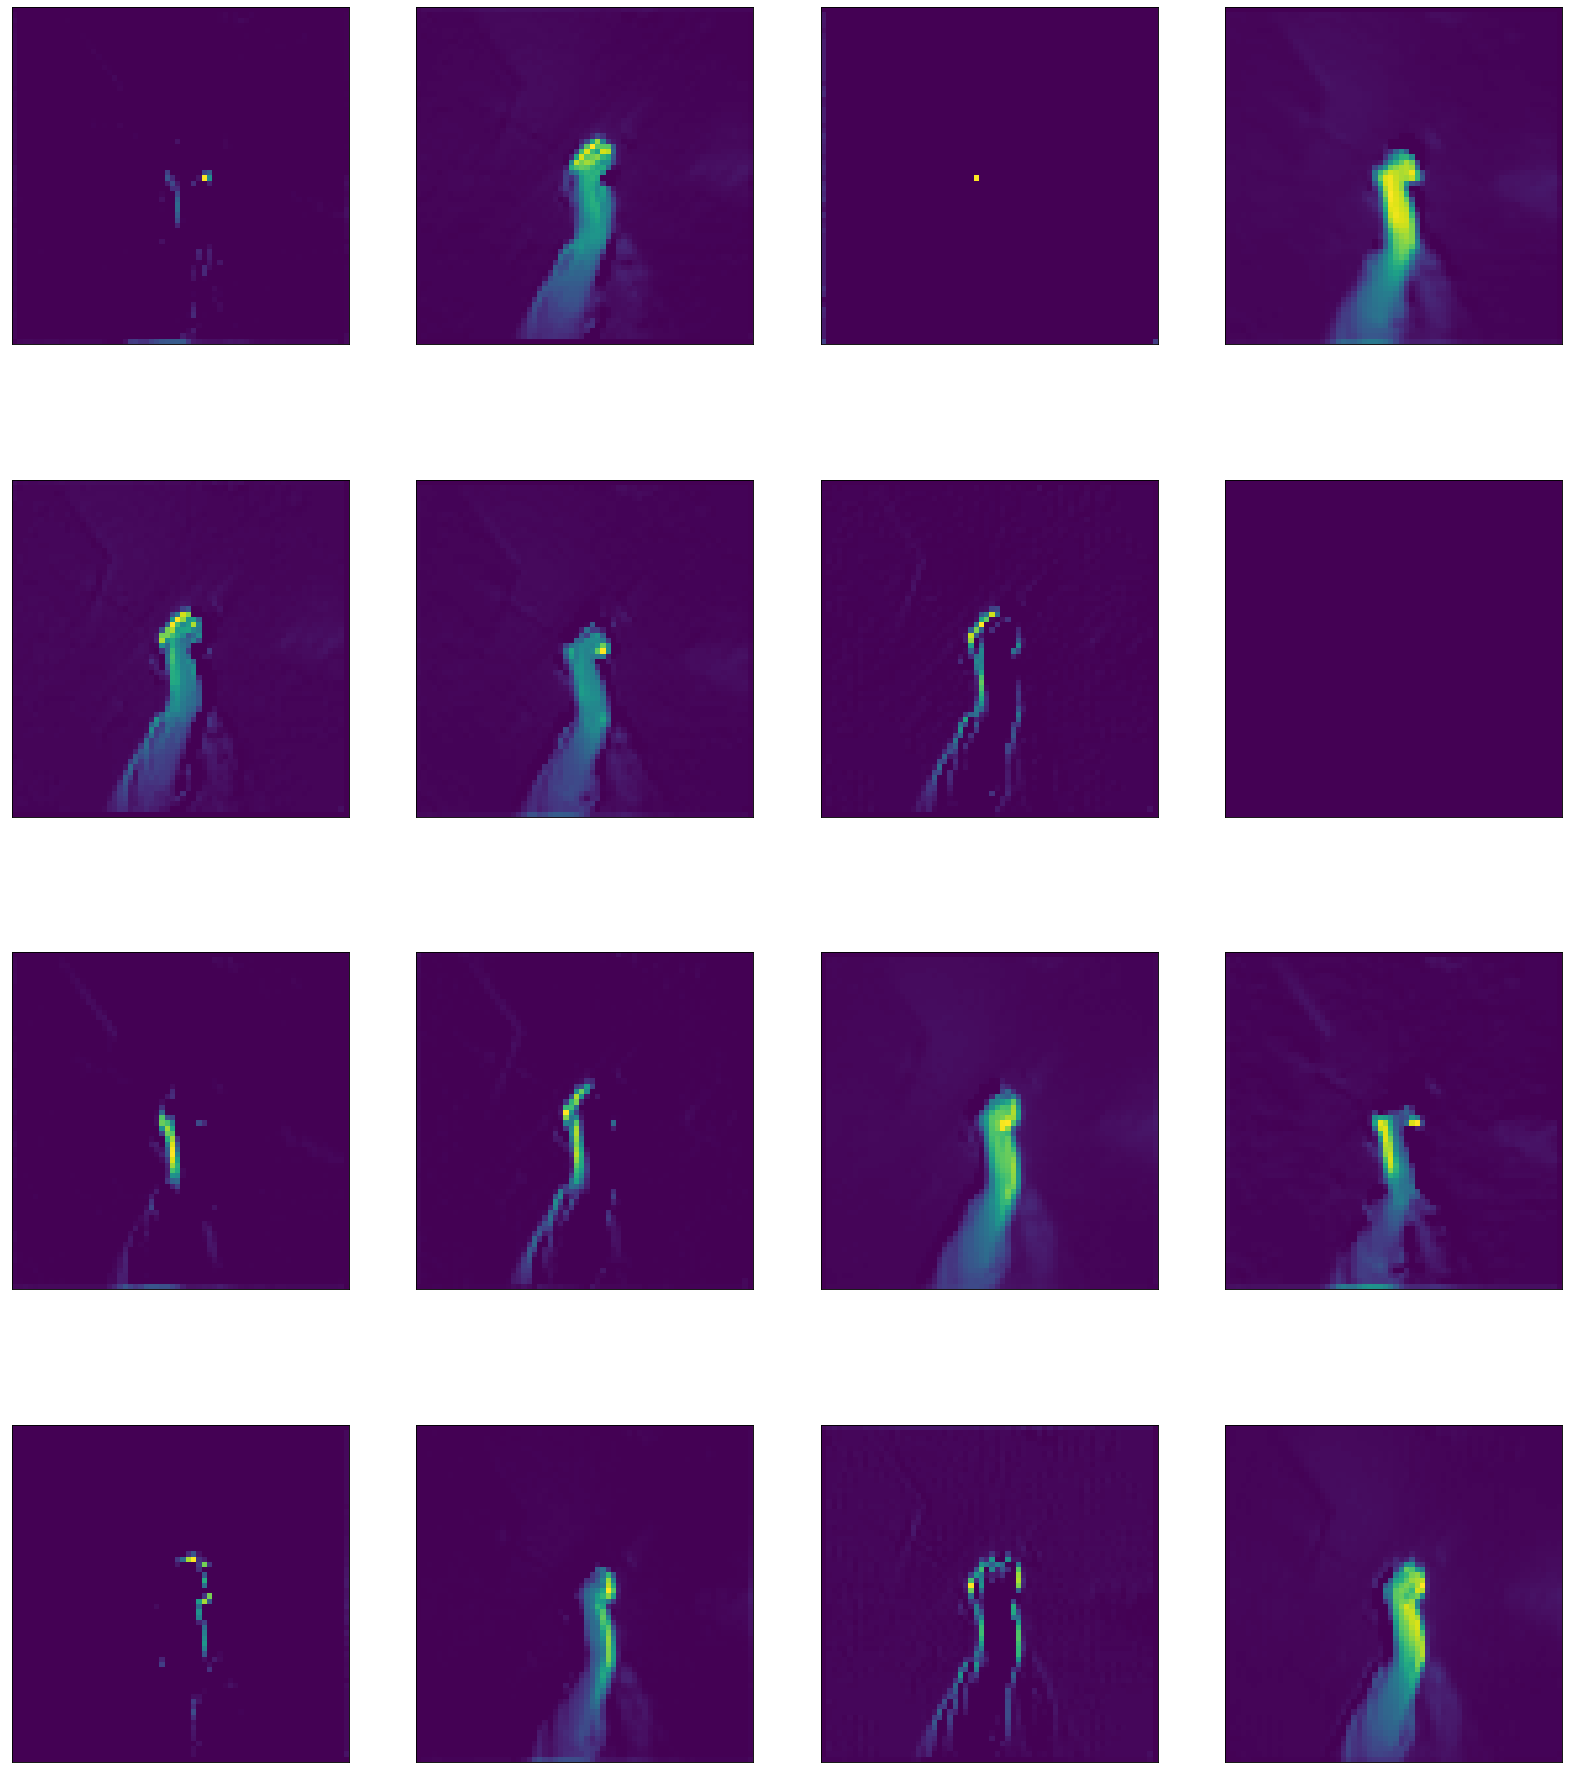

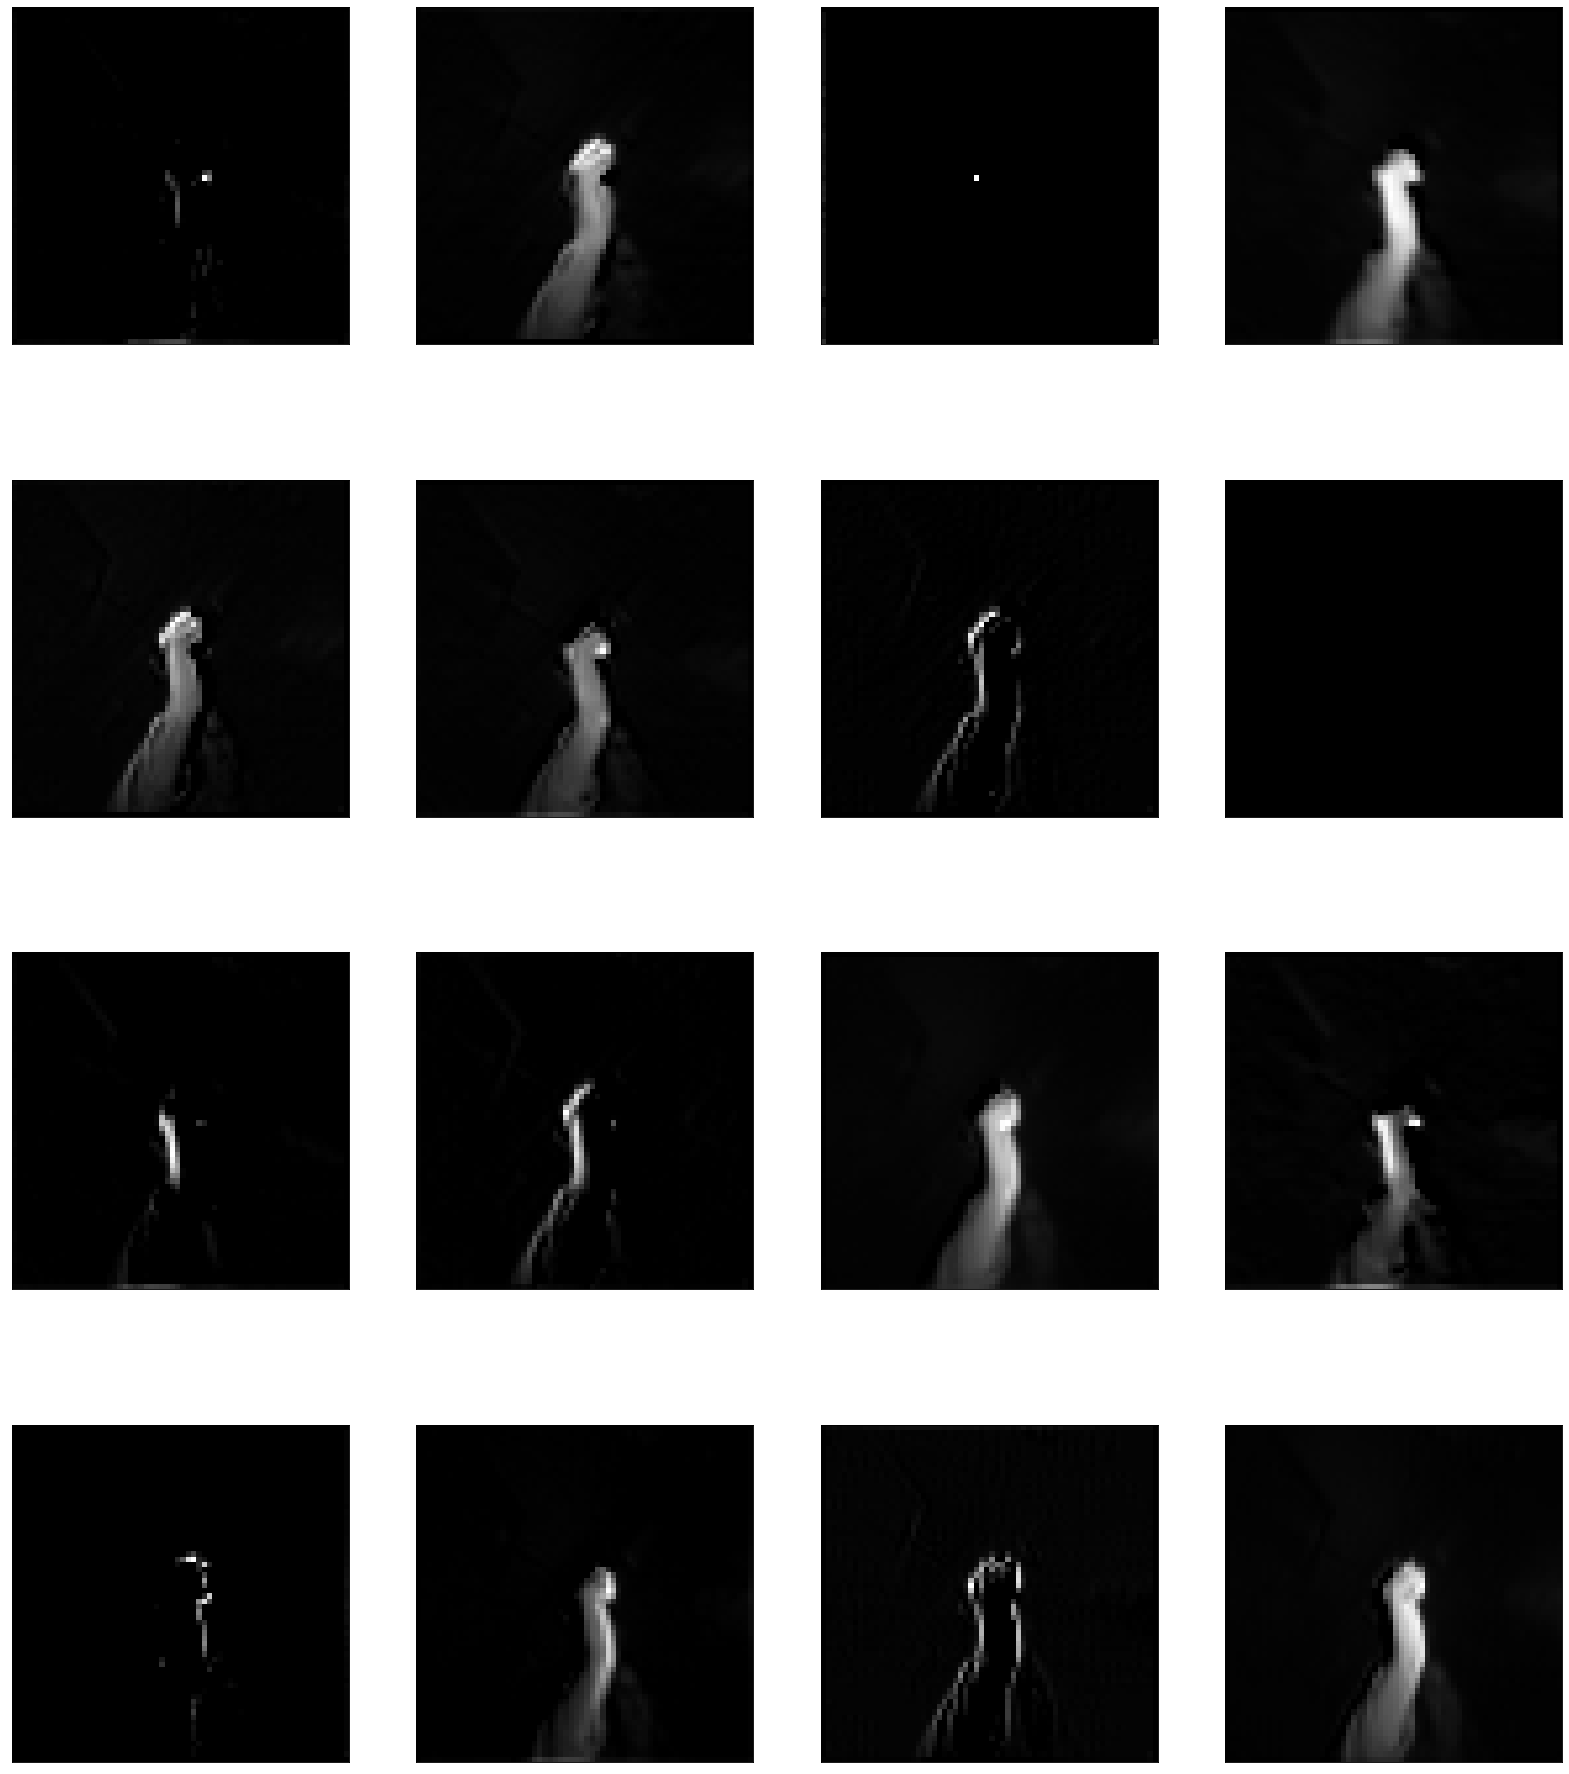

In [ ]:
image_transform(X[56])
image_transform_gray(X[56])

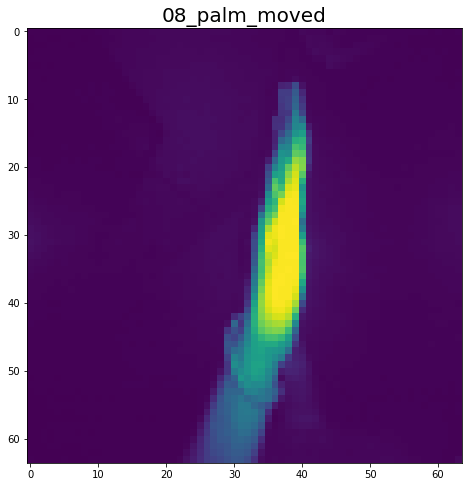

In [ ]:
plt.figure(figsize=(25,8))
plt.imshow(X[1566].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,10))[0][0],size = 20)
plt.show()

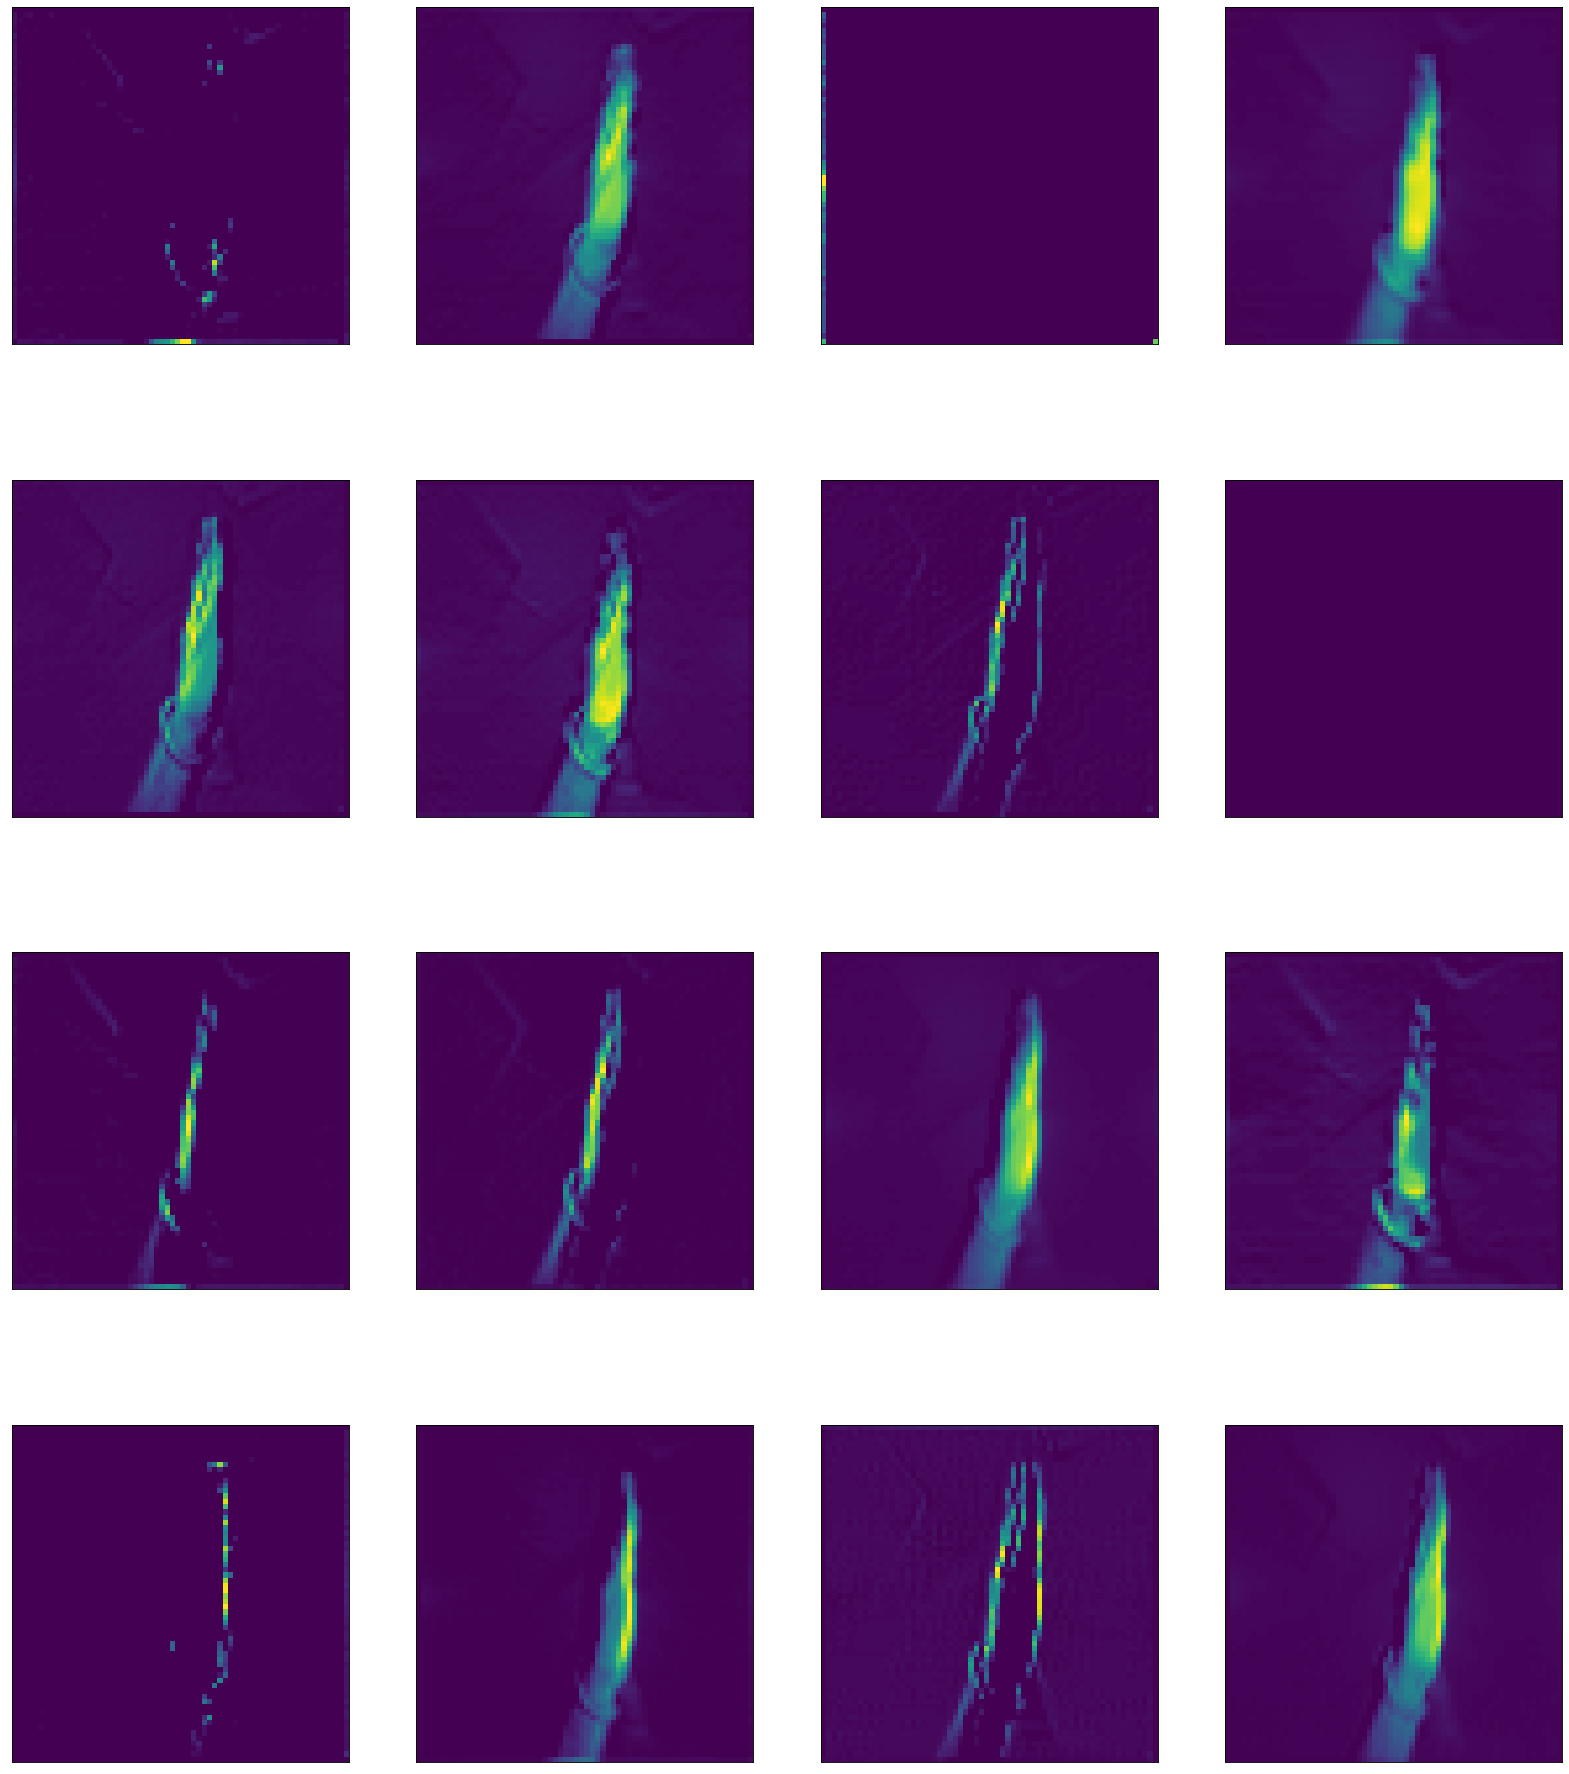

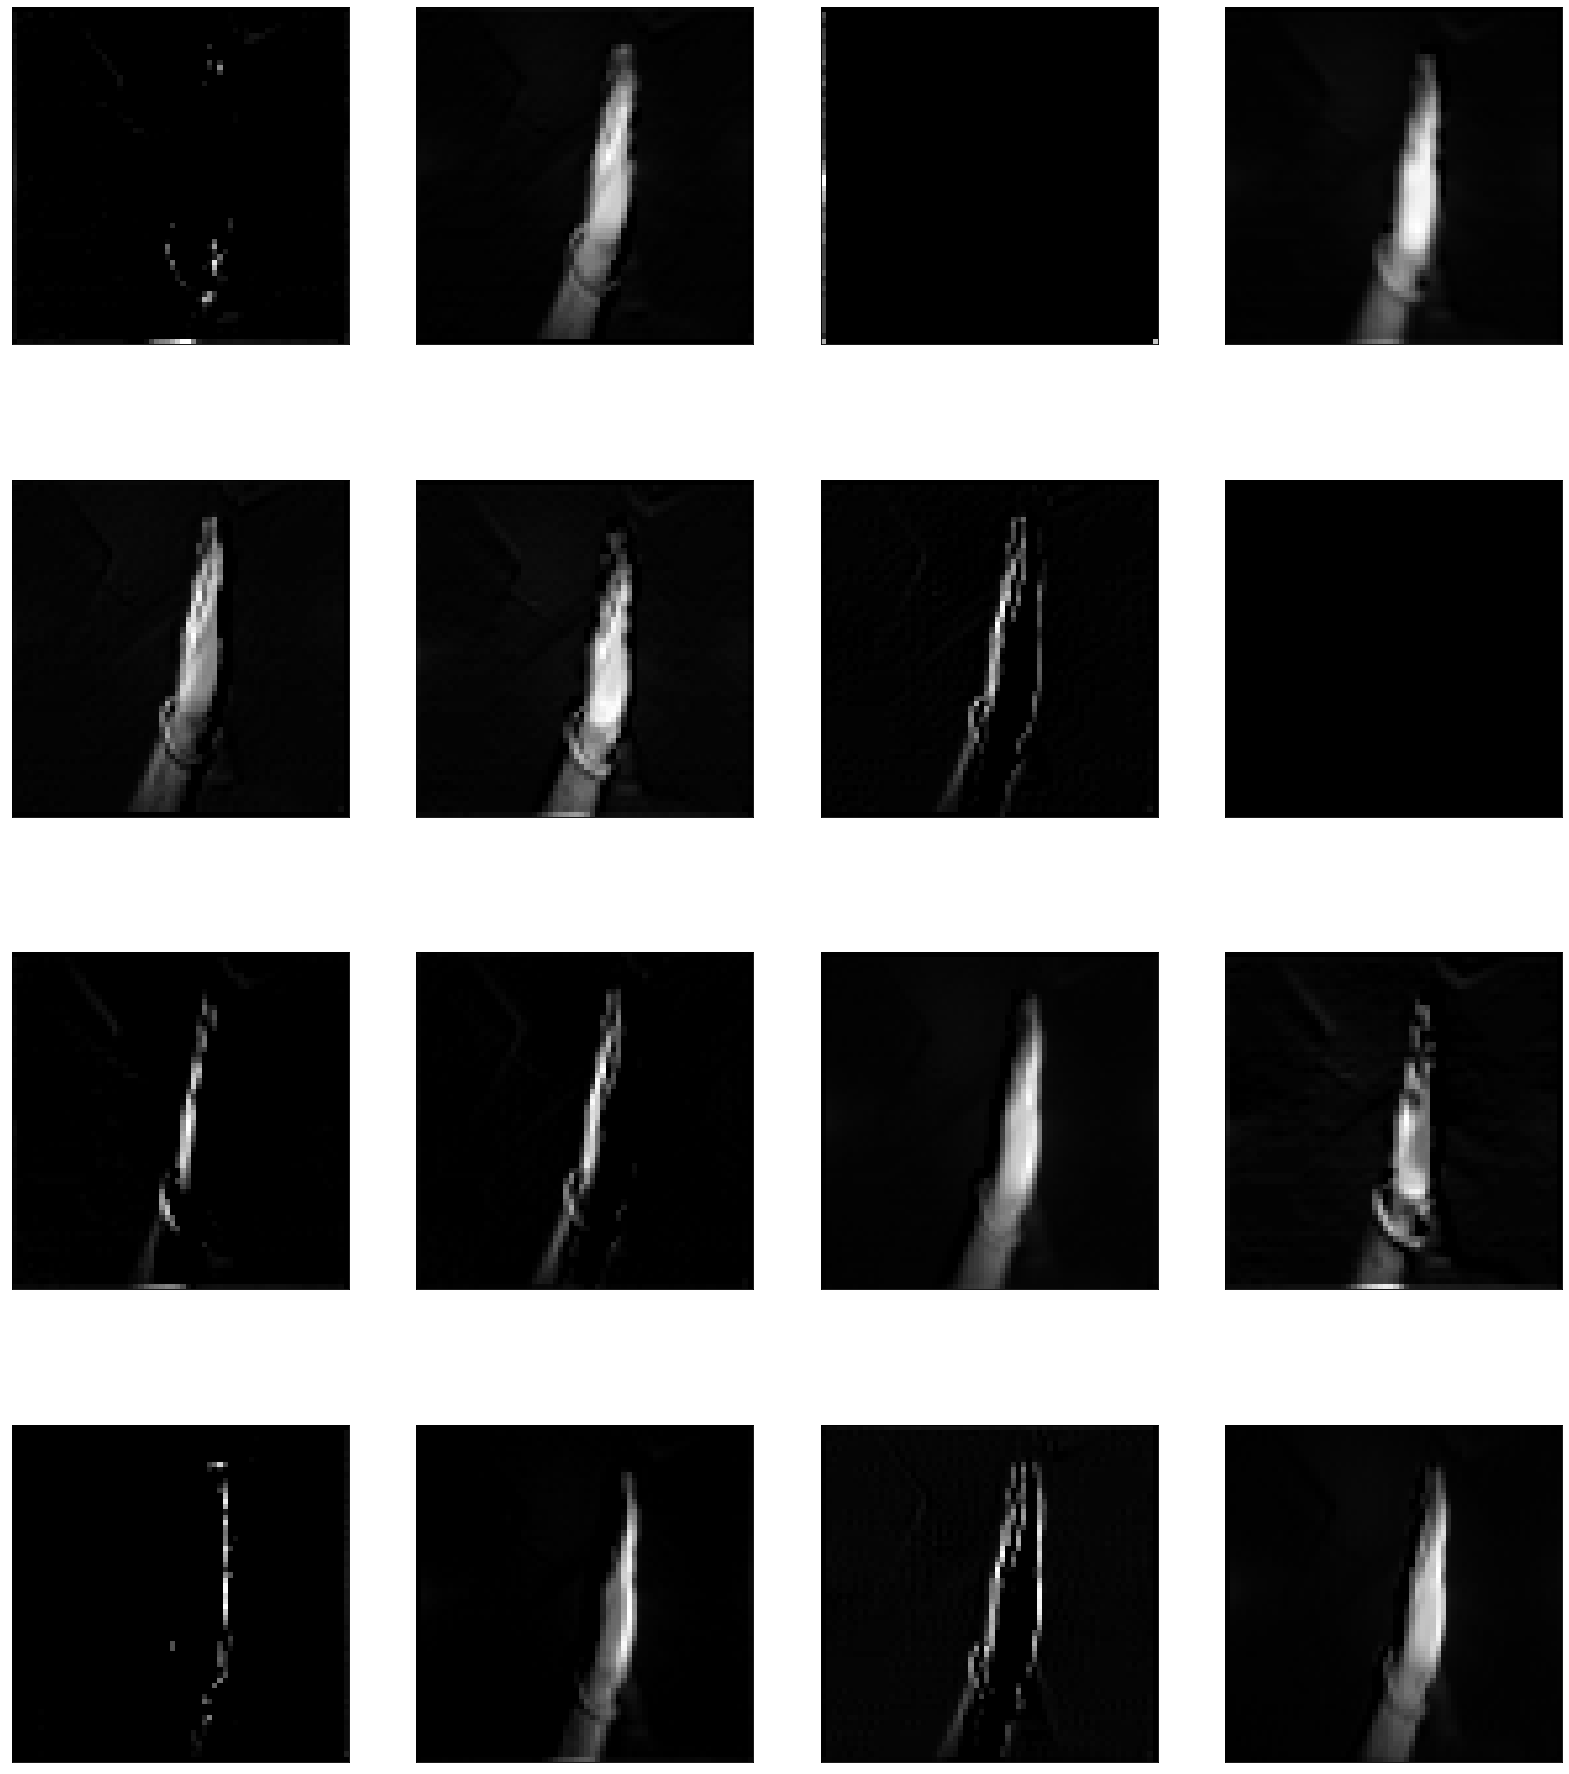

In [ ]:
image_transform(X[1566])
image_transform_gray(X[1566])

# Test The Results

In [ ]:
y_pred = model.evaluate(X_test , y_test,verbose =1)

63/63 [==============================] - 0s 6ms/step - loss: 6.1378e-04 - accuracy: 0.9995 - precision: 1.0000 - recall: 5.0000e-04


In [ ]:
y_pred[1]

0.9994999766349792

In [ ]:
history.history['loss'][49]
import plotly.graph_objects as go


fig = go.Figure(data=[
    go.Bar(name = 'Accuracy',x=['Training','Validation','Real World Data'], y=[history.history['accuracy'][49] ,history.history['val_accuracy'][49],y_pred[1] ]),
    go.Bar(name = 'Precision',x=['Training','Validation','Real World Data'], y=[history.history['precision'][49] ,history.history['val_precision'][49],y_pred[2] ]),
    go.Bar(name = 'Loss',x=['Training','Validation','Real World Data'], y=[history.history['loss'][49] ,history.history['val_loss'][49],y_pred[0] ]),

])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_yaxes(type = "log")
pyo.iplot(fig, filename = 'Act_train_rec')

In [ ]:
model.predict(X_test)

array([[7.1185173e-16, 8.4889015e-15, 1.1272411e-03, ..., 3.9355827e-17,
        2.1837333e-16, 8.4819662e-17],
       [3.1370037e-16, 1.3478394e-17, 6.7932101e-16, ..., 6.4750295e-17,
        1.0244135e-15, 1.9525338e-16],
       [9.9181301e-16, 1.1075332e-14, 1.8669424e-15, ..., 2.5182934e-03,
        1.5126812e-14, 7.8622154e-16],
       ...,
       [5.1365348e-16, 2.8147902e-18, 1.3240868e-16, ..., 1.4973794e-16,
        3.8536926e-18, 3.4399872e-19],
       [2.7812356e-16, 2.7290624e-18, 3.5008606e-17, ..., 1.9928221e-16,
        1.8901571e-18, 6.6125906e-18],
       [2.2936019e-16, 1.5199489e-18, 4.5563803e-16, ..., 8.5216954e-17,
        1.0701977e-17, 8.9483499e-19]], dtype=float32)

In [ ]:
y_prediction = model.predict(X_test)
def binary_classify(y_pred):
    for inp in y_pred:
        maximum = 0
        index = 0
        for i in range(10):
            if(maximum != max(maximum,inp[i])):
                maximum = max(maximum,inp[i])
                index = i
            inp[i] = 0
        inp[index]=1
    return y_pred
y_prediction  = binary_classify(y_prediction)

In [ ]:
def create_result(y):
    y_final = []
    for i in range(y.shape[0]):
        y_final.append(enc.inverse_transform(y[i].reshape(1,10))[0][0])
    return y_final
def remove_none(y , y_pred):
    index = []
    for i in range(len(y)-1,0,-1):
        if y_pred[i] == None :
            del y[i]
            del y_pred[i]

    return y , y_pred
def label_encode(y , y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y_pred)
    print(le.classes_)
    y = le.transform(y)
    y_pred = le.transform(y_pred)
    return y , y_pred

y_class_result = create_result(y_prediction)
y_class_desired = create_result(y_test)

In [ ]:
y_label_desired , y_label_result = label_encode(y_class_desired , y_class_result)

['01_palm' '02_l' '03_fist' '04_fist_moved' '05_thumb' '06_index' '07_ok'
 '08_palm_moved' '09_c' '10_down']


In [ ]:
from sklearn.metrics import classification_report
tn = []
for cat in enc.categories_[0].reshape(10,1):
    tn.append(cat[0])
target_names = tn
print(classification_report(y_label_desired, y_label_result, target_names=target_names))

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       177
         02_l       1.00      1.00      1.00       216
      03_fist       1.00      1.00      1.00       187
04_fist_moved       1.00      1.00      1.00       215
     05_thumb       1.00      1.00      1.00       231
     06_index       1.00      1.00      1.00       189
        07_ok       1.00      1.00      1.00       192
08_palm_moved       1.00      1.00      1.00       213
         09_c       1.00      1.00      1.00       177
      10_down       1.00      1.00      1.00       203

     accuracy                           1.00      2000
    macro avg       1.00      1.00      1.00      2000
 weighted avg       1.00      1.00      1.00      2000



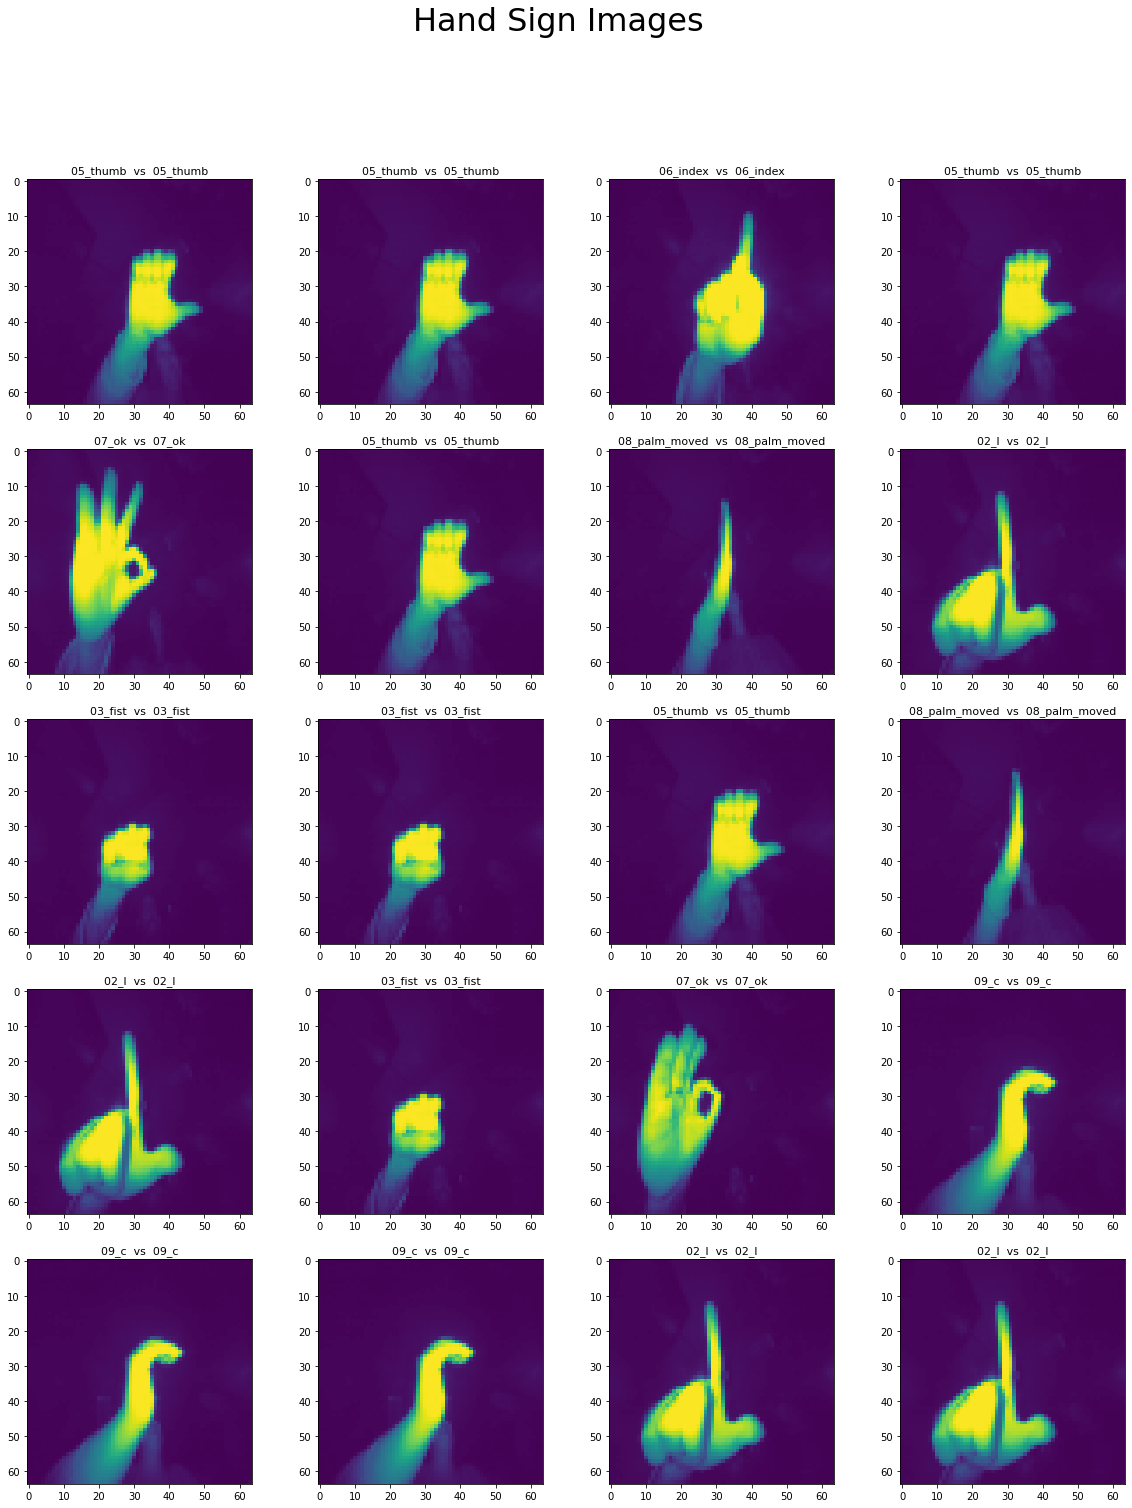

In [ ]:
count = 1
f = plt.figure(figsize=(20,24))
for i in range(20):
    ind = random.sample(list(y_label_result),1)[0]
    img = X_test[ind]
    Class = str(y_class_desired[ind]) + '  vs  '+str(y_class_result[ind])
    ax = f.add_subplot(5, 4,count)
    ax = plt.imshow(img.reshape(w,h))
    ax = plt.title(Class,fontsize= 11)
    count = count + 1
plt.suptitle("Hand Sign Images", size = 32)
plt.show()